In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [246]:
from convolve import convolve, nearest_power_of_two
from basic_stu import STU
from lds_utils import compute_ar_x_preds
from lds import LDS

In [11]:
flash_fft_available = False
dtype = torch.bfloat16 if flash_fft_available else torch.float32

use_hankel_L  = False
phi = torch.tensor(np.load('spectral_filters.npy')).to(device).to(dtype)
seq_len, num_eigh = 8192, 24    
# phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L, device  = device,  dtype = torch.float32)
#I have checked that phi from the file and from get_spectral_filters are the same up to precision and sign
n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)

class Config:
    def __init__(self):
        self.num_eigh = num_eigh
        self.use_hankel_L = use_hankel_L
        self.torch_dtype = dtype
        self.n_embd = 10  # d_in and d_out
        self.seq_len = seq_len
        self.k_u = 0
        self.use_flash_fft = flash_fft_available
        self.use_approx = False

stu_config = Config()


In [32]:
# Define the path to the saved data
save_dir = "fit_filters_216"

combined_weights = np.load(os.path.join(save_dir, "optimized_weights.npy"))

# Load the saved LDS models
lds_params = []

# Path to the saved LDS models
lds_models_dir = save_dir

# Load all 488 LDS models
for i in range(480):
    model_path = os.path.join(lds_models_dir, f"lds_model_{i}.pth")
    if os.path.exists(model_path):
        # Load the model with weights_only=True to avoid security warnings
        model_state = torch.load(model_path, weights_only=True)
        new_lds = LDS(1, 1, 1, 0)
        new_lds.load_state_dict(model_state)
        lds_params.append(new_lds)
    

print(f"Loaded {len(lds_params)} LDS models")


Loaded 216 LDS models


In [33]:
# Extract A, B, and C matrices from all LDS models
A_matrices = []
B_matrices = []
C_matrices = []

for lds in lds_params:
    # Extract parameters from each LDS model
    A_matrices.append(lds.A.detach().clone())
    B_matrices.append(lds.B.detach().clone())
    C_matrices.append(lds.C.detach().clone())

# Stack all matrices
stacked_A = torch.stack(A_matrices)
stacked_B = torch.stack(B_matrices)
stacked_C = torch.stack(C_matrices)

# Print shapes to verify
print(f"Stacked A shape: {stacked_A.shape}")
print(f"Stacked B shape: {stacked_B.shape}")
print(f"Stacked C shape: {stacked_C.shape}")


BC = (stacked_B * stacked_C).reshape(-1)
A = stacked_A.reshape(-1)


Stacked A shape: torch.Size([216, 1])
Stacked B shape: torch.Size([216, 1, 1])
Stacked C shape: torch.Size([216, 1, 1])


In [12]:
stu = STU(stu_config, phi, n) #input dim 10, output dim 10


In [13]:
#so naive implementation has an LDS for every coordinate pair
#smarter implementation just has an LDS for each coordinate and different matrix output

torch.Size([24, 10, 10])

In [197]:
# Create tensors for LDS parameters
A_tensor = torch.tensor(A, dtype=torch.float32)
BC_tensor = torch.tensor(BC, dtype=torch.float32)
combined_weights = torch.tensor(combined_weights, dtype=torch.float32)

# Load an LDS with input dim 1 and output dim 48
lds_model = LDS(A_tensor.shape[0], input_dim=1, output_dim=48, kx = 0)
lds_model.A.data = A_tensor
lds_model.B.data  = BC_tensor.unsqueeze(dim = 0)
lds_model.C.data = combined_weights
lds_model.h0.data = torch.zeros_like(lds_model.h0.data)


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_19305/1427763835.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tensor = torch.tensor(A, dtype=torch.float32)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_19305/1427763835.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  BC_tensor = torch.tensor(BC, dtype=torch.float32)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_19305/1427763835.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  combined_weights = torch.tensor(combined_weights, dtype=torch.

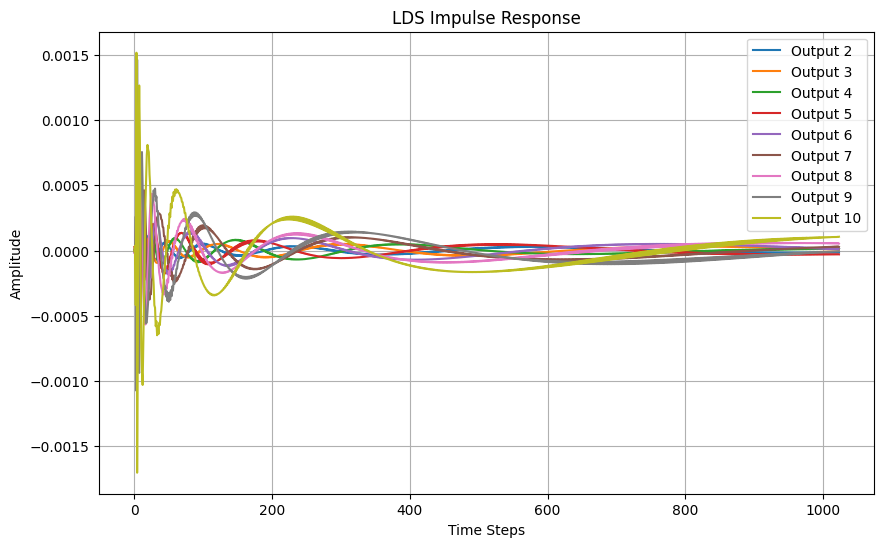

Impulse response shape: torch.Size([1024, 48, 1])


In [198]:
# Generate the impulse response for the LDS model
impulse_response = lds_model.impulse()

# Display the impulse response using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot the first few columns of the impulse response
for i in range(1,10):
    plt.plot(impulse_response[:, i].detach().cpu().numpy(), label=f'Output {i+1}')

plt.title('LDS Impulse Response')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Print shape for reference
print(f"Impulse response shape: {impulse_response.shape}")


In [240]:
class FastSTU(nn.Module):
    def __init__(self, config, lds) -> None:
        super(FastSTU, self).__init__()
        self.config = config
        
        self.n = nearest_power_of_two(config.seq_len * 2 - 1, round_up=True)
        self.K = config.num_eigh
        self.d_in = config.n_embd
        self.d_out = config.n_embd
        self.use_hankel_L = config.use_hankel_L
        self.use_approx = False
        self.k_u = config.k_u
        self.lds = lds

        self.M = nn.Parameter(torch.randn(self.d_out, self.d_in, self.k_u, dtype=config.torch_dtype) / self.d_in)
        
        self.M_phi_plus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config.torch_dtype) / 10
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config.torch_dtype) / 10
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Convolve inputs and filters,
        #x is B, L, d_in
        #
        bsz = x.shape[0]
        U = torch.stack([self.lds(x[:,i].reshape(bsz,-1,1)) for i in range(x.shape[1])], axis = 1) #B, L, d_in, K
        # Swap last two axes of U to make it (B, L, K, d_in)
        U = U.permute(0, 1, 3, 2)  # From (B, L, d_in, K) to (B, L, K, d_in)
        U_plus, U_minus = U[:,:,:24,:], U[:,:,24:,:]
        
        # Then, contract over the K and d_in dimensions

        # print(U_plus.shape, U_minus.shape)
        spectral_plus = torch.tensordot(
            U_plus, self.M_phi_plus, dims=([2, 3], [0, 1])
        )

        spectral_minus = torch.tensordot(
            U_minus, self.M_phi_minus, dims=([2, 3], [0, 1])
        )
        
        output = spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus
        
        if self.M.shape[-1] != 0:
            ar = compute_ar_x_preds(self.M, x)
            return output + ar
        
        return output
        
    def loss(self, inputs, targets):
        pred = self.forward(inputs)
        # print(pred, targets)
        loss = F.mse_loss(pred, targets)
        return  loss



In [241]:
fast_stu = FastSTU(stu_config, lds_model)
fast_stu.M_phi_minus.data = stu.M_phi_minus.data
fast_stu.M_phi_plus.data = stu.M_phi_plus.data

In [236]:
# Set up parameters for evaluation
batch_size = 8
seq_len = 11
d_in = 10
d_out = 10

# Create random Gaussian input data
random_input = torch.randn(batch_size, seq_len, d_in)

# Set models to evaluation mode
stu.eval()
fast_stu.eval()

# Forward pass through both models
with torch.no_grad():
    stu_output = stu(random_input)
    fast_stu_output = fast_stu(random_input)

print(f"Shape of STU output: {stu_output.shape}")
print(f"Shape of Fast STU output: {fast_stu_output.shape}")

# Compare outputs
mse_diff = F.mse_loss(stu_output, fast_stu_output)
max_diff = torch.max(torch.abs(stu_output - fast_stu_output))

print(f"MSE between STU and Fast STU outputs: {mse_diff.item():.8f}")
print(f"Maximum absolute difference: {max_diff.item():.8f}")


Shape of STU output: torch.Size([8, 11, 10])
Shape of Fast STU output: torch.Size([8, 11, 10])
MSE between STU and Fast STU outputs: nan
Maximum absolute difference: nan


tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<AddBackward0>)